In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

from boruta import BorutaPy

from src import classes as c
from src import functions as f
import matplotlib.pyplot as plt
import seaborn as sns

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

In [5]:
# creating f1 scorer
f1 = f.f1

In [6]:
modeling = c.Harness(f1)

## Baseline Dataframe

Dropping engineered features to establish the baseline score.

In [7]:
# excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
#              'Call Type', 'Officer Squad', 'Frisk Flag', 'Weapon Flag',
#              'Reported Year', 'Reported Month','Day of Month',
#              'Day of Week', 'Reported Hour', 'Beat Flag']

In [8]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [9]:
# excluding Officer ID, 'Final Call Type', and Frisk Flag
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [10]:
baseline_df = f.framer(df, [], excluded)

In [11]:
baseline_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct
0,1,NA,None,1984,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South
1,0,NA,None,1965,M,White,NA,NA,NA,NA,NA,NA


In [12]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Weapon Type               46960 non-null  object
 3   Officer YOB               46960 non-null  int64 
 4   Officer Gender            46960 non-null  object
 5   Officer Race              46960 non-null  object
 6   Subject Perceived Race    46960 non-null  object
 7   Subject Perceived Gender  46960 non-null  object
 8   Initial Call Type         46960 non-null  object
 9   Call Type                 46960 non-null  object
 10  Officer Squad             46960 non-null  object
 11  Precinct                  46960 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.3+ MB


In [13]:
X, y = f.Xy(baseline_df)

In [14]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

## Baseline Logistic Regression

In [15]:
LR = LogisticRegression(max_iter=1000, random_state = 2021, verbose=2)

In [16]:
baseline = make_pipeline(preprocessing_mm, LR)

In [17]:
baseline.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [18]:
#scoring the model
f1_score(baseline.predict(X_train), y_train)

0.3276439089692102

In [19]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'LR Baseline', 'Log Reg, min/max')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR Baseline has an average F1 of 0.3084601376131168


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


array([0.32475083, 0.31168831, 0.31262855, 0.28534814, 0.30788486])

## Sub-Splitting the Training Data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


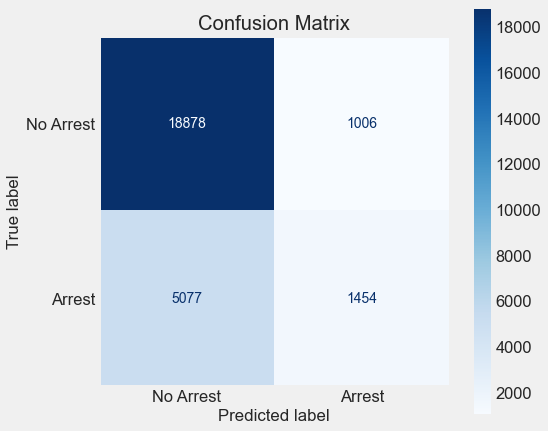

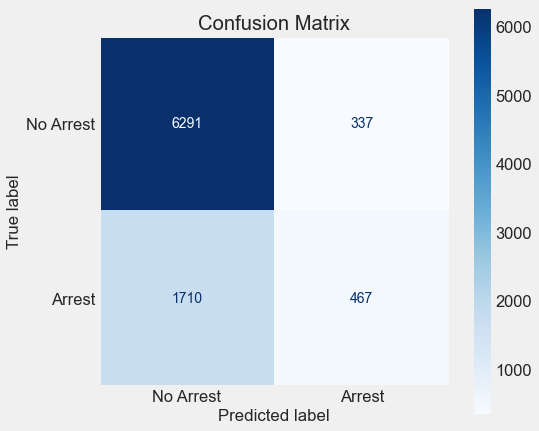

,Train F1,Test F1
0,0.323435,0.313318


In [20]:
f.subsplit_test(X_train, y_train, baseline)

## Baseline Logistic Regression w/smote

In [21]:
baseline_smote = make_sm_pipeline(preprocessing_mm, sm, LR)

In [22]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [23]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5337012539057744

In [24]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR Baseline SMOTE', 'Log Reg min/max')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR Baseline SMOTE has an average F1 of 0.5230351427268607


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


array([0.52399117, 0.51822025, 0.52830949, 0.52266667, 0.52198814])

In [25]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR Baseline SMOTE,0.523035,Log Reg min/max


## Sub-Splitting the Training Data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


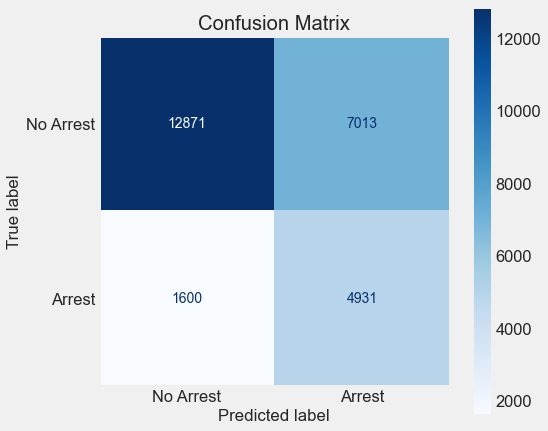

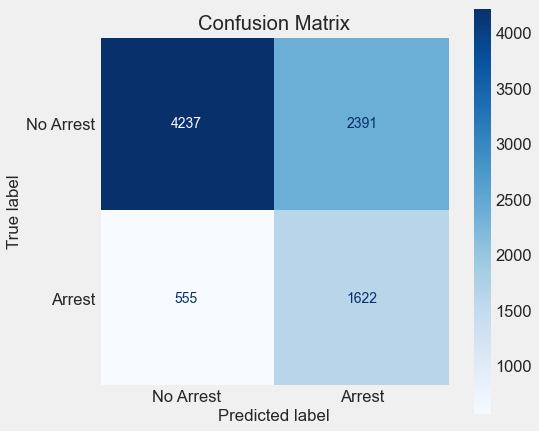

,Train F1,Test F1
0,0.533802,0.524071


In [26]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Investigating the Data More Closely

In [27]:
cols = baseline_df.columns
for col in cols:
    print(f'{df[col].value_counts()}\n')

0    35349
1    11611
Name: Target, dtype: int64

26 - 35         15630
36 - 45          9966
18 - 25          9409
46 - 55          6069
56 and Above     2385
1 - 17           1971
NA               1530
Name: Subject Age Group, dtype: int64

None                                    32375
NA                                      11806
Lethal Cutting Instrument                1477
Knife/Cutting/Stabbing Instrument         629
Handgun                                   290
Firearm Other                              98
Blunt Object/Striking Implement            86
Club, Blackjack, Brass Knuckles            48
Firearm                                    38
Mace/Pepper Spray                          28
Other Firearm                              23
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        9
None/Not Applicable                         7
Rifle                                       6
Fire/Incendiary Devic

In [28]:
baseline_df['Officer YOB'].describe()

count    46960.000000
mean      1982.972764
std          9.079240
min       1900.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

## Creating & Testing Officer Age Feature
Creating `Officer Age` feature, dropping invalid ages and `Officer YOB` feature.

In [29]:
df['Officer Age'] = df['Reported Year'] - df['Officer YOB']
df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
df.dropna(subset = ['Officer Age'], inplace=True)

In [30]:
df.drop('Officer YOB', axis=1, inplace=True)

In [31]:
age_df = f.framer(df, [], excluded)

In [32]:
age_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Age
0,1,NA,None,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,31.0
1,0,NA,None,M,White,NA,NA,NA,NA,NA,NA,50.0


In [33]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46925 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    46925 non-null  int64  
 1   Subject Age Group         46925 non-null  object 
 2   Weapon Type               46925 non-null  object 
 3   Officer Gender            46925 non-null  object 
 4   Officer Race              46925 non-null  object 
 5   Subject Perceived Race    46925 non-null  object 
 6   Subject Perceived Gender  46925 non-null  object 
 7   Initial Call Type         46925 non-null  object 
 8   Call Type                 46925 non-null  object 
 9   Officer Squad             46925 non-null  object 
 10  Precinct                  46925 non-null  object 
 11  Officer Age               46925 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 4.7+ MB


In [34]:
X, y = f.Xy(age_df)

In [35]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [36]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [37]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.534804200928112

In [38]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'Log Reg mm, officer age')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE has an average F1 of 0.5237333711219279


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


array([0.52206186, 0.51786075, 0.53281378, 0.52228525, 0.52364522])

In [39]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR Baseline SMOTE,0.523035,Log Reg min/max
2,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


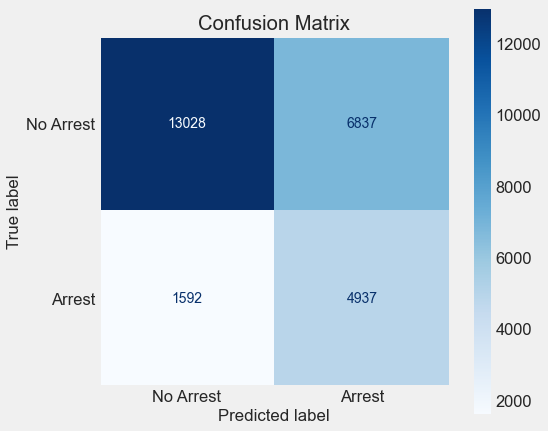

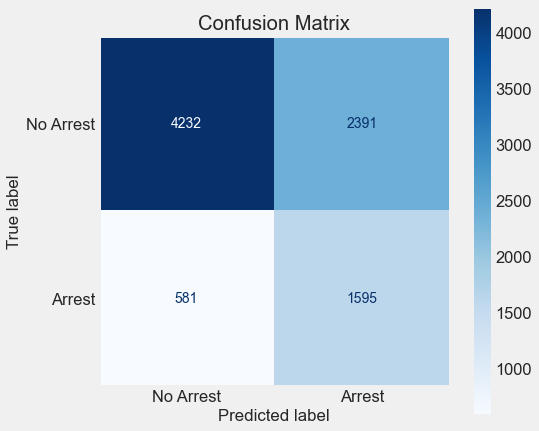

,Train F1,Test F1
0,0.539474,0.517689


In [40]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Creating Racial Affinity Feature

In [41]:
df['Racial Affinity'] = [1 if df['Subject Perceived Race'][row]\
                         == df['Officer Race'][row] else 0 for row in df.index]

In [42]:
df.head(3)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Precinct,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity
0,1,NA,None,7500,M,Black,Asian,Male,NA,NA,...,South,1,2015,10,16,4,11,1,31.0,0
1,0,NA,None,5670,M,White,NA,NA,NA,NA,...,NA,1,2015,3,19,3,7,0,50.0,0
2,0,NA,None,4844,M,White,White,Male,NA,NA,...,NA,1,2015,3,21,5,19,0,54.0,1


In [43]:
# excluding Officer ID, 'Final Call Type', and Frisk Flag
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age']

In [44]:
RA_df = f.framer(df, [], excluded)

In [45]:
RA_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Racial Affinity
0,1,NA,None,M,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
1,0,NA,None,M,White,NA,NA,NA,NA,NA,NA,0


In [46]:
X, y = f.Xy(RA_df)

In [47]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [48]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [49]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5342766528421566

In [50]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Log Reg, mm, racial affinity')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE  has an average F1 of 0.522497072617619


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


array([0.52059308, 0.51456116, 0.53469388, 0.5233871 , 0.51925015])

In [51]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
3,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
1,LR Baseline SMOTE,0.523035,Log Reg min/max
2,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


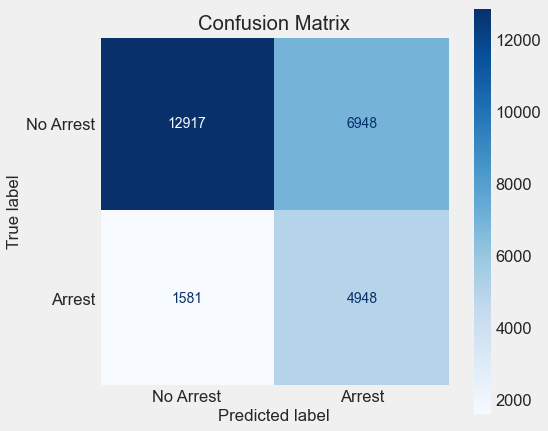

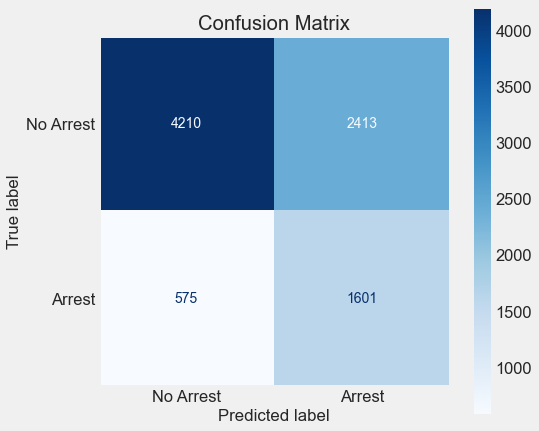

,Train F1,Test F1
0,0.537096,0.517286


In [52]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Gender Affinity Feature

In [53]:
df['Officer Gender'].value_counts()

M    41552
F     5373
Name: Officer Gender, dtype: int64

In [54]:
df['Officer Gender'] = df['Officer Gender'].apply(lambda x: 'Male' if x=='M' else 'Female')

In [55]:
df['Gender Affinity'] = [1 if df['Subject Perceived Gender'][row]\
                         == df['Officer Gender'][row] else 0 for row in df.index]

In [56]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,1,2015,10,16,4,11,1,31.0,0,1
1,0,NA,None,5670,Male,White,NA,NA,NA,NA,...,1,2015,3,19,3,7,0,50.0,0,0


In [57]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity']

In [58]:
GA_df = f.framer(df, [], excluded)

In [59]:
GA_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Gender Affinity
0,1,NA,None,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,1
1,0,NA,None,Male,White,NA,NA,NA,NA,NA,NA,0


In [60]:
X, y = f.Xy(GA_df)

In [61]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [62]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [63]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5334524921802007

In [64]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Log Reg, mm, gender affinity')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE  has an average F1 of 0.522011067139893


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


array([0.51885432, 0.51268731, 0.53387589, 0.52323232, 0.52140549])

In [65]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
4,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
1,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
2,LR Baseline SMOTE,0.523035,Log Reg min/max
3,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


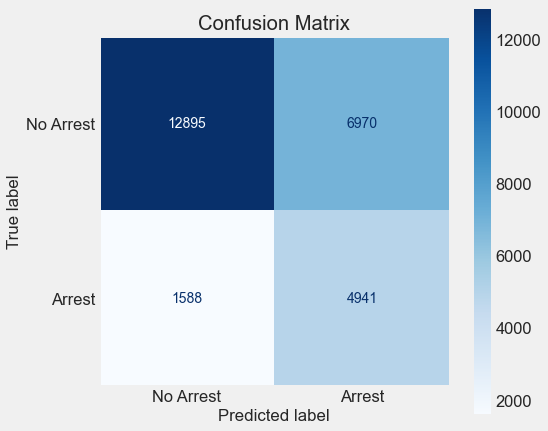

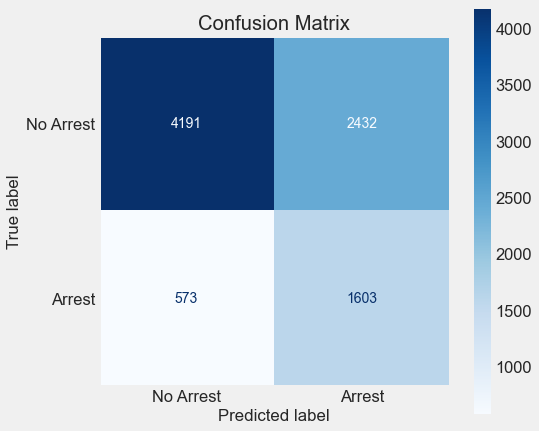

,Train F1,Test F1
0,0.5359,0.516181


In [66]:
f.subsplit_test(X_train, y_train, baseline_smote)

### Weapon Type

In [67]:
# checking weapon types
df['Weapon Type'].unique()

array(['None', 'Firearm Other', 'Lethal Cutting Instrument', 'Handgun',
       'NA', 'Club, Blackjack, Brass Knuckles',
       'Knife/Cutting/Stabbing Instrument', 'Other Firearm',
       'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
       'Firearm (unk type)', 'Mace/Pepper Spray', 'None/Not Applicable',
       'Club', 'Rifle', 'Firearm', 'Taser/Stun Gun', 'Shotgun',
       'Brass Knuckles', 'Automatic Handgun', 'Blackjack',
       'Personal Weapons (hands, feet, etc.)'], dtype=object)

In [68]:
NONE= ['None', 'NA','None/Not Applicable']

GUN = ['Firearm Other', 'Handgun', 'Other Firearm',
        'Rifle', 'Firearm (unk type)', 'Firearm',
        'Shotgun', 'Automatic Handgun']

KNIFE = ['Lethal Cutting Instrument', 'Knife/Cutting/Stabbing Instrument']

OTHER = ['Club, Blackjack, Brass Knuckles',
         'Fire/Incendiary Device', 'Blunt Object/Striking Implement',
         'Mace/Pepper Spray', 'Club', 'Taser/Stun Gun',
         'Brass Knuckles','Blackjack',
         'Personal Weapons (hands, feet, etc.)']

In [69]:
df['Weapon Bins'] = df['Weapon Type'].copy()

In [70]:
df['Weapon Bins']

0                                     None
1                                     None
2                                     None
3                                     None
4                                     None
                       ...                
46955    Knife/Cutting/Stabbing Instrument
46956                                   NA
46957                        Other Firearm
46958                                   NA
46959                                   NA
Name: Weapon Bins, Length: 46925, dtype: object

In [71]:
for type in NONE:
    df['Weapon Bins'].replace(type, 'NONE', inplace=True)
for type in GUN:
    df['Weapon Bins'].replace(type, 'GUN', inplace=True)
for type in KNIFE:
    df['Weapon Bins'].replace(type, 'KNIFE', inplace=True)
for type in OTHER:
    df['Weapon Bins'].replace(type, 'OTHER', inplace=True)

In [72]:
df['Weapon Bins'].value_counts(normalize=True)

NONE     0.940948
KNIFE    0.044859
GUN      0.010123
OTHER    0.004070
Name: Weapon Bins, dtype: float64

## 94% of Subjects Are Unarmed and Only 1% Have a Gun.

In [73]:
df.head(2)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity,Weapon Bins
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,2015,10,16,4,11,1,31.0,0,1,NONE
1,0,NA,None,5670,Male,White,NA,NA,NA,NA,...,2015,3,19,3,7,0,50.0,0,0,NONE


In [74]:
excluded = ['Weapon Type', 'Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity']

In [75]:
WB_df = f.framer(df, [], excluded)

In [76]:
WB_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Weapon Bins
0,1,NA,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,NONE
1,0,NA,Male,White,NA,NA,NA,NA,NA,NA,NONE


In [77]:
X, y = f.Xy(WB_df)

In [78]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [79]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [80]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5337064979313701

In [81]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Log Reg, mm, Weapon Bins')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE  has an average F1 of 0.5210381622950484


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


array([0.51832139, 0.51183313, 0.5346815 , 0.52469506, 0.51565973])

In [82]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
5,LR SMOTE,0.521038,"Log Reg, mm, Weapon Bins"
1,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
2,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
3,LR Baseline SMOTE,0.523035,Log Reg min/max
4,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


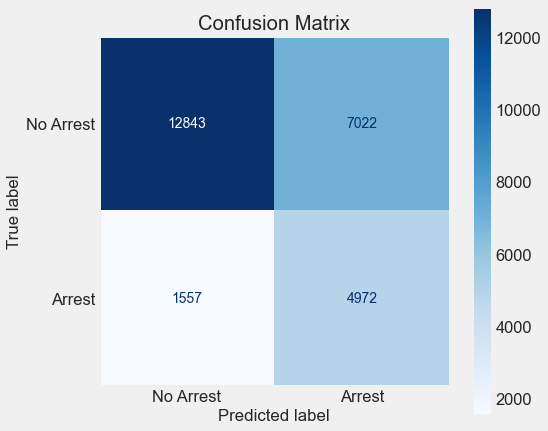

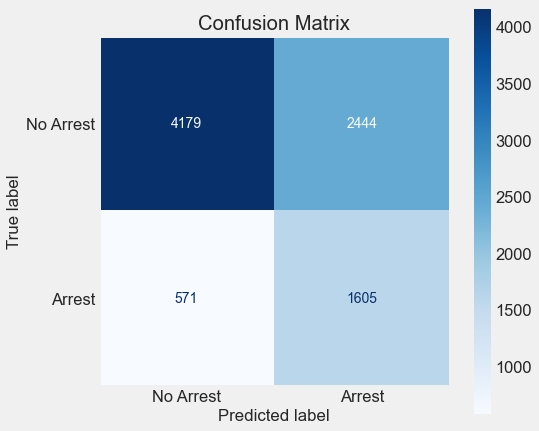

,Train F1,Test F1
0,0.536846,0.515663


In [83]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing Weapon Flag
The weapon flag (0 = no weapon) has been excluded from tests up to this point.

In [84]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Type', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins']

In [85]:
WF_df = f.framer(df, [], excluded)

In [86]:
WF_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Weapon Flag
0,1,NA,Male,Black,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,1
1,0,NA,Male,White,NA,NA,NA,NA,NA,NA,1


In [87]:
X, y = f.Xy(WF_df)

In [88]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [89]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [90]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5282594733461786

In [91]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Log Reg, mm, weapon flag')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE  has an average F1 of 0.5161278746709819


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


array([0.51166565, 0.51015532, 0.53181273, 0.51979414, 0.50721154])

In [92]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
6,LR SMOTE,0.516128,"Log Reg, mm, weapon flag"
1,LR SMOTE,0.521038,"Log Reg, mm, Weapon Bins"
2,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
3,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
4,LR Baseline SMOTE,0.523035,Log Reg min/max
5,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


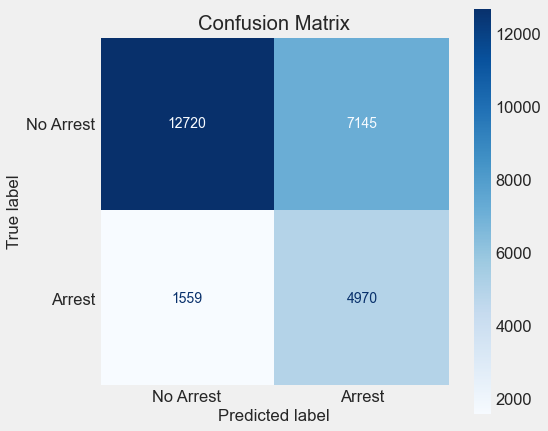

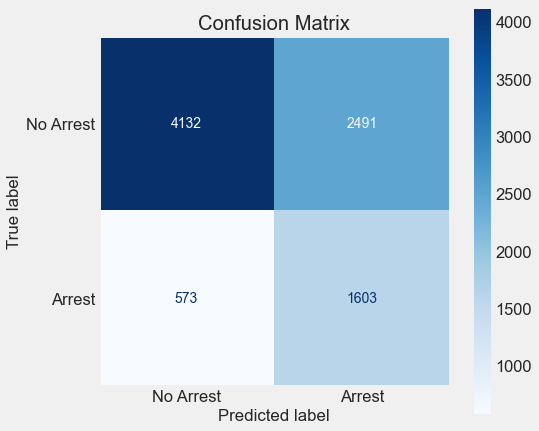

,Train F1,Test F1
0,0.533147,0.511324


In [93]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binarizing Initial Call Type
0 = no call information provided.

In [94]:
df['Initial Call Bin'] = df['Initial Call Type'].copy()

In [95]:
df['Initial Call Bin'] = df['Initial Call Bin'].replace('NA', 0)
df['Initial Call Bin'] = df['Initial Call Bin'].map(lambda x: 1 if x!=0 else 0)

In [96]:
df['Initial Call Bin'].value_counts()

1    33854
0    13071
Name: Initial Call Bin, dtype: int64

In [97]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 'Initial Call Type']

In [98]:
ICB_df = f.framer(df, [], excluded)

In [99]:
ICB_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Call Type,Officer Squad,Precinct,Initial Call Bin
0,1,NA,None,Male,Black,Asian,Male,NA,SOUTH PCT 1ST W - ROBERT,South,0
1,0,NA,None,Male,White,NA,NA,NA,NA,NA,0


In [100]:
X, y = f.Xy(ICB_df)

In [101]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [102]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [103]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5073970997509888

In [104]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Log Reg, mm, Initial Call Binary')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE  has an average F1 of 0.500166897705118


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


array([0.50138351, 0.49382716, 0.50691244, 0.50083041, 0.49788097])

In [105]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
7,LR SMOTE,0.500167,"Log Reg, mm, Initial Call Binary"
1,LR SMOTE,0.516128,"Log Reg, mm, weapon flag"
2,LR SMOTE,0.521038,"Log Reg, mm, Weapon Bins"
3,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
4,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
5,LR Baseline SMOTE,0.523035,Log Reg min/max
6,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


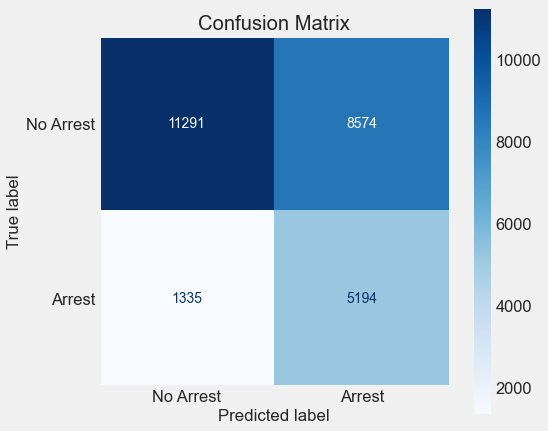

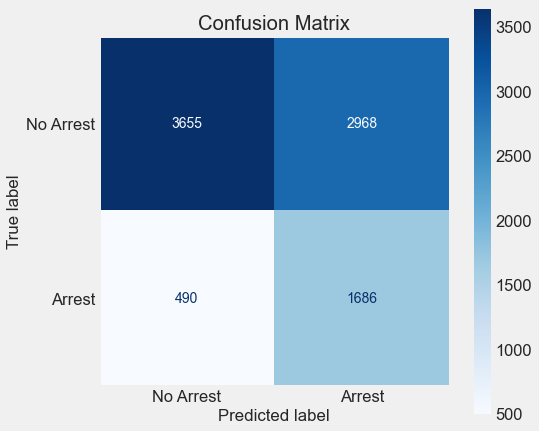

,Train F1,Test F1
0,0.5118,0.493704


In [106]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binning Call Types

In [107]:
types = df['Call Type'].unique()

In [108]:
replace_list = [x for x in types if (x!='911') and (x!='ONVIEW')]

In [109]:
df['Call Type Bins'] = df['Call Type'].copy()

In [110]:
df['Call Type Bins'] = df['Call Type Bins'].replace(replace_list, 'OTHER')

In [111]:
df['Call Type Bins'].value_counts(normalize=True)

911       0.452211
OTHER     0.355631
ONVIEW    0.192158
Name: Call Type Bins, dtype: float64

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46925 entries, 0 to 46959
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    46925 non-null  int64  
 1   Subject Age Group         46925 non-null  object 
 2   Weapon Type               46925 non-null  object 
 3   Officer ID                46925 non-null  object 
 4   Officer Gender            46925 non-null  object 
 5   Officer Race              46925 non-null  object 
 6   Subject Perceived Race    46925 non-null  object 
 7   Subject Perceived Gender  46925 non-null  object 
 8   Initial Call Type         46925 non-null  object 
 9   Final Call Type           46925 non-null  object 
 10  Call Type                 46925 non-null  object 
 11  Officer Squad             46925 non-null  object 
 12  Frisk Flag                46925 non-null  int64  
 13  Precinct                  46925 non-null  object 
 14  Weapon

In [113]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type']

In [114]:
BCT_df = f.framer(df, [], excluded)

In [115]:
BCT_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Officer Squad,Precinct,Call Type Bins
0,1,NA,None,Male,Black,Asian,Male,NA,SOUTH PCT 1ST W - ROBERT,South,OTHER
1,0,NA,None,Male,White,NA,NA,NA,NA,NA,OTHER


In [116]:
X, y = f.Xy(BCT_df)

In [117]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [118]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [119]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5347058344861259

In [120]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE ', 'Log Reg, mm, call type bins')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE  has an average F1 of 0.5215220821585239


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


array([0.52039555, 0.51340996, 0.53485528, 0.52179177, 0.51715785])

In [121]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.500167,"Log Reg, mm, Initial Call Binary"
2,LR SMOTE,0.516128,"Log Reg, mm, weapon flag"
3,LR SMOTE,0.521038,"Log Reg, mm, Weapon Bins"
8,LR SMOTE,0.521522,"Log Reg, mm, call type bins"
4,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
5,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
6,LR Baseline SMOTE,0.523035,Log Reg min/max
7,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


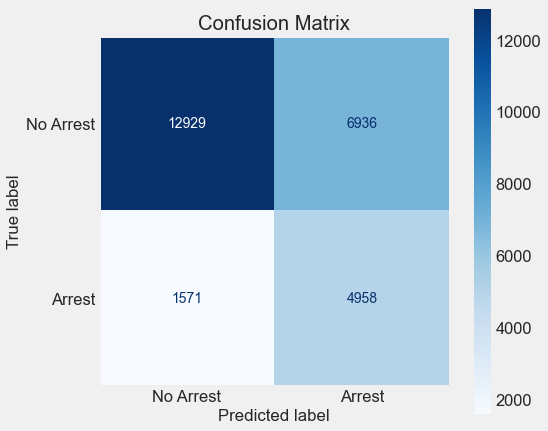

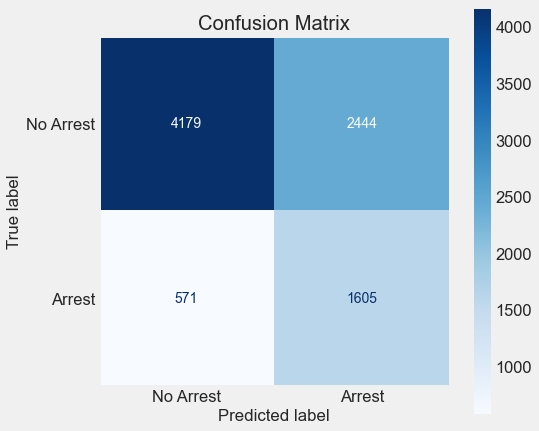

,Train F1,Test F1
0,0.53824,0.515663


In [122]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binning the Squad Data
The squads look like they can be binned into precinct goups and a training group.

In [123]:
df['Officer Squad Bins'] = df['Officer Squad'].copy()

In [124]:
df['Officer Squad Bins'] = df['Officer Squad Bins'].map(lambda x: x[0])

In [125]:
df['Officer Squad Bins'].value_counts(normalize=True)

W    0.273372
N    0.248993
S    0.214427
E    0.138604
T    0.110304
C    0.010314
G    0.001598
H    0.000725
M    0.000384
B    0.000277
J    0.000213
R    0.000213
D    0.000192
A    0.000170
P    0.000107
O    0.000064
V    0.000021
Z    0.000021
Name: Officer Squad Bins, dtype: float64

In [126]:
proportions = df['Officer Squad Bins'].value_counts(normalize=True)
cutoff_idx = proportions.loc[proportions < .02].index
for i in cutoff_idx:
    df['Officer Squad Bins'].replace(i, 'OTHER', inplace=True)

In [127]:
df['Officer Squad Bins'].value_counts()

W        12828
N        11684
S        10062
E         6504
T         5176
OTHER      671
Name: Officer Squad Bins, dtype: int64

In [128]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad']

In [129]:
BSQ_df = f.framer(df, [], excluded)

In [130]:
BSQ_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Precinct,Officer Squad Bins
0,1,NA,None,Male,Black,Asian,Male,NA,NA,South,S
1,0,NA,None,Male,White,NA,NA,NA,NA,NA,N


In [131]:
X, y = f.Xy(BSQ_df)

In [132]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [133]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [134]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.518883676552437

In [135]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'Log Reg, mm, Squad Bins')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE has an average F1 of 0.5122978508598516


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.5037457 , 0.50303862, 0.51981858, 0.51945487, 0.51543149])

In [136]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.500167,"Log Reg, mm, Initial Call Binary"
9,LR SMOTE,0.512298,"Log Reg, mm, Squad Bins"
2,LR SMOTE,0.516128,"Log Reg, mm, weapon flag"
3,LR SMOTE,0.521038,"Log Reg, mm, Weapon Bins"
4,LR SMOTE,0.521522,"Log Reg, mm, call type bins"
5,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
6,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
7,LR Baseline SMOTE,0.523035,Log Reg min/max
8,LR SMOTE,0.523733,"Log Reg mm, officer age"


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


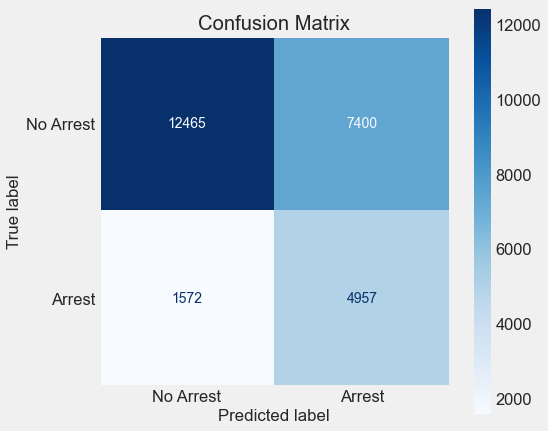

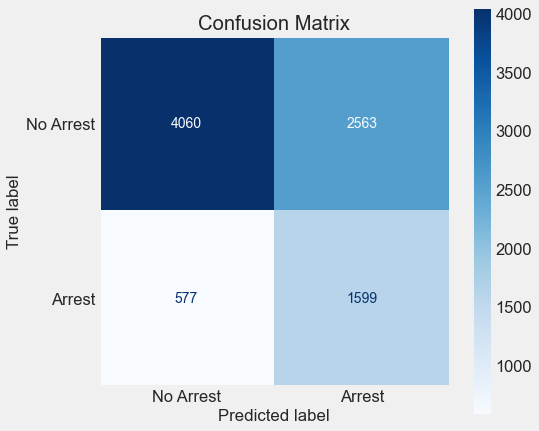

,Train F1,Test F1
0,0.524939,0.504576


In [137]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Binning Officer Race

In [138]:
df['Officer Race Bins'] = df['Officer Race'].copy()

In [139]:
df['Officer Race Bins'].replace('White', 1, inplace=True)

In [140]:
df['Officer Race Bins'] = df['Officer Race Bins'].apply(lambda x: 0 if x!=1 else 1)

In [141]:
df['Officer Race Bins'].value_counts()

1    35465
0    11460
Name: Officer Race Bins, dtype: int64

In [142]:
excluded = ['Officer ID','Final Call Type', 'Frisk Flag','Weapon Flag', 
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Officer Age',
            'Racial Affinity', 'Gender Affinity', 'Weapon Bins', 
            'Initial Call Bin','Call Type Bins', 'Officer Squad Bins',
            'Officer Race']

In [143]:
ORB_df = f.framer(df, [], excluded)

In [144]:
ORB_df.head(2)

,Target,Subject Age Group,Weapon Type,Officer Gender,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Officer Squad,Precinct,Officer Race Bins
0,1,NA,None,Male,Asian,Male,NA,NA,SOUTH PCT 1ST W - ROBERT,South,0
1,0,NA,None,Male,NA,NA,NA,NA,NA,NA,1


In [145]:
X, y = f.Xy(ORB_df)

In [146]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [147]:
baseline_smote.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777034070>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb777029be0>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=2021,
                                    verbose=2))])

In [148]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

0.5335971571636245

In [149]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE', 'Log Reg, mm, Officer Race Bins')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

LR SMOTE has an average F1 of 0.5214269568459626


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


array([0.51914368, 0.51184263, 0.53485528, 0.52305825, 0.51823494])

In [150]:
modeling.history

,Name,Accuracy,Notes
0,LR Baseline,0.308460,"Log Reg, min/max"
1,LR SMOTE,0.500167,"Log Reg, mm, Initial Call Binary"
2,LR SMOTE,0.512298,"Log Reg, mm, Squad Bins"
3,LR SMOTE,0.516128,"Log Reg, mm, weapon flag"
4,LR SMOTE,0.521038,"Log Reg, mm, Weapon Bins"
10,LR SMOTE,0.521427,"Log Reg, mm, Officer Race Bins"
5,LR SMOTE,0.521522,"Log Reg, mm, call type bins"
6,LR SMOTE,0.522011,"Log Reg, mm, gender affinity"
7,LR SMOTE,0.522497,"Log Reg, mm, racial affinity"
8,LR Baseline SMOTE,0.523035,Log Reg min/max


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


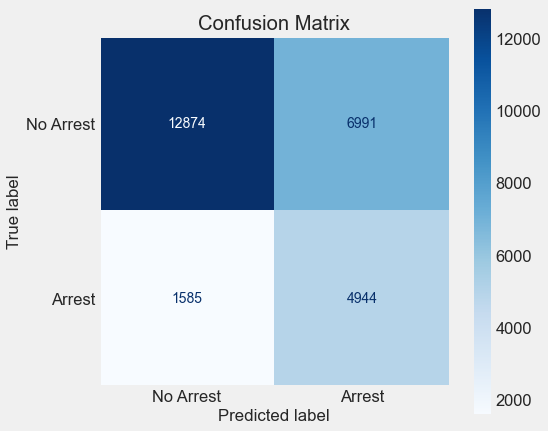

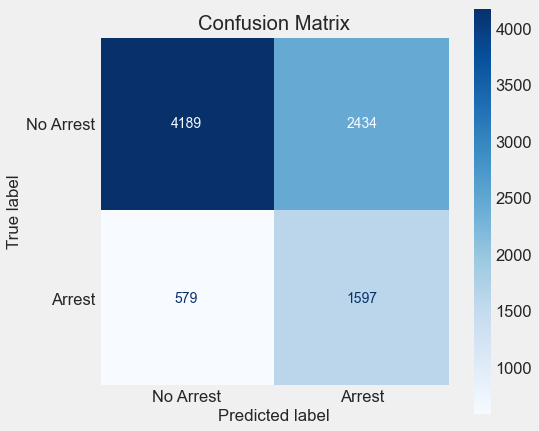

,Train F1,Test F1
0,0.535529,0.51458


In [151]:
f.subsplit_test(X_train, y_train, baseline_smote)

## Testing Dropping Nulls
Droppin Subject Race Nulls

In [ ]:
dropd = df[(df['Subject Perceived Race']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
excluded = ['Officer ID','Frisk Flag','Weapon Flag', 'Final Call Type',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Racial Affinity',
            'Gender Affinity', 'Officer Age']

In [ ]:
df_4 = f.framer(dropd, [], excluded)

In [ ]:
df_4.head()

In [ ]:
X, y = f.Xy(df_4)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
baseline_smote.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE New Age, Race, Gender Features', 'Dropped Subject Race NA')

In [ ]:
modeling.history

## Dropping Officer Race Nulls

In [ ]:
dropd2 = df[(df['Subject Perceived Race']!='NA') &\
           (df['Officer Race']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
excluded = ['Officer ID','Frisk Flag','Weapon Flag', 'Final Call Type',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Racial Affinity',
            'Gender Affinity', 'Officer Age']

In [ ]:
df_5 = f.framer(dropd2, [], excluded)

In [ ]:
df_5.head(2)

In [ ]:
df_5.info()

In [ ]:
X, y = f.Xy(df_5)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
baseline_smote.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train, 'LR SMOTE New Age, Race, Gender Features', 'Drpd S Race, O Race NA')

In [ ]:
modeling.history

## Dropping Subject Age Nulls

In [ ]:
dropd3 = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')&\
            (df['Subject Age Group']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
excluded = ['Officer ID','Frisk Flag','Weapon Flag', 'Final Call Type',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag', 'Racial Affinity',
            'Gender Affinity', 'Officer Age']

In [ ]:
df_6 = f.framer(dropd3, [], excluded)

In [ ]:
df_6.head(2)

In [ ]:
df_6.info()

In [ ]:
X, y = f.Xy(df_6)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
baseline_smote.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train,\
                'LR SMOTE Dpd Nulls S Race, O Race NA, S Age')

In [ ]:
modeling.history

## Testing of all features

In [ ]:
dropd3 = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')&\
            (df['Subject Age Group']!='NA')]

In [ ]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour']

In [ ]:
excluded = ['Officer ID','Frisk Flag','Weapon Flag', 'Final Call Type',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour']

In [ ]:
df_6 = f.framer(dropd3, [], excluded)

In [ ]:
df_6.head(2)

In [ ]:
df_6.info()

In [ ]:
X, y = f.Xy(df_6)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
baseline_smote.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(baseline_smote.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(baseline_smote, X_train, y_train,\
                'LR SMOTE Dpd Nulls S Race, O Race NA, S Age')

In [ ]:
modeling.history

## Testing on Sub-Splits

In [ ]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [ ]:
lr_smote6.fit(Xs_train, ys_train)

In [ ]:
f1_score(lr_smote6.predict(Xs_train), ys_train)

In [ ]:
f1_score(lr_smote6.predict(Xs_test), ys_test)

In [ ]:
f.confusion(lr_smote6, Xs_train, ys_train)

In [ ]:
f.confusion(lr_smote6, Xs_test, ys_test)

## Binarizing Final Call Type

In [ ]:
df['Final Call Type'] = df['Final Call Type'].replace('NA', 0)
df['Final Call Type'] = df['Final Call Type'].map(lambda x: 1 if x!=0 else 0)

In [ ]:
df['Final Call Type'].value_counts(normalize=True)

## Balanced Class Weights

In [ ]:
LR_bal = LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
lr_smote7 = make_sm_pipeline(preprocessing, sm, LR_bal)

In [ ]:
lr_smote7.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(lr_smote7.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(lr_smote7, X_train, y_train, 'LR_bal', 'Dpd Nulls S Race, O Race NA, S Age')

In [ ]:
modeling.history

## Checking C Values

## Rough Estimate By Hand

In [ ]:
# # preprocessing
# string_selector = make_column_selector(dtype_include='object')
# number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')
# preprocessing = make_column_transformer((OneHotEncoder
#                                          (handle_unknown='ignore'),string_selector),
#                                           (StandardScaler(), number_selector))
# # C = [0.001,.009,0.01,.09,1,5,10,25]
# C = np.logspace(-3, 3, 7)
# for c in C:
#     LR_clf = LogisticRegression(class_weight='balanced', C=c, max_iter=1000)
#     # make_pipeline from imblearn
#     sm = SMOTE(random_state=2021) 
#     pipeline  = make_sm_pipeline(preprocessing, sm, LR_clf)
#     pipeline.fit(X_train, y_train)
#     modeling.report(pipeline, X_train, y_train, 'LR_bal', f'C={c}')
# f1_score(pipeline.predict(X_train), y_train)

In [ ]:
modeling.history

## Grid Searching Parameters

In [ ]:
LR_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2021)

pipeline  = make_sm_pipeline(preprocessing, sm, LR_clf)
pipeline.fit(X_train, y_train)

C = np.logspace(-3, 3, 7)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']

grid_values = {'logisticregression__C':C, 
               'logisticregression__penalty':penalty,
               'logisticregression__solver':solver }

grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, n_jobs=-1, scoring = 'f1')
grid_clf_f1.fit(X_train, y_train)

In [ ]:
print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])

In [ ]:
LR_tuned = LogisticRegression(class_weight='balanced', C=.001,
                            solver='liblinear', penalty='l2',
                            max_iter=1000, random_state=2021)

pipeline  = make_sm_pipeline(preprocessing, sm, LR_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_tuned', 'C=.01, solver=liblinear, penalty=l1')

In [ ]:
modeling.history

## Testing Tuned Model on Sub-Splits

In [ ]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [ ]:
pipeline  = make_sm_pipeline(preprocessing, sm, LR_tuned)
pipeline.fit(Xs_train, ys_train)

In [ ]:
f1_score(pipeline.predict(Xs_train), ys_train)

In [ ]:
f1_score(pipeline.predict(Xs_test), ys_test)

In [ ]:
f.confusion(pipeline, Xs_train, ys_train)

In [ ]:
f.confusion(pipeline, Xs_test, ys_test)

## Adding Polynomial Features

In [ ]:
preprocessing2 = make_column_transformer((PolynomialFeatures(degree=5, interaction_only=True), number_selector),
                                         (OneHotEncoder(handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))

In [ ]:
preprocessing2.fit_transform(X_train);

In [ ]:
lr_poly = make_sm_pipeline(preprocessing2, sm, LR_tuned)

In [ ]:
lr_poly.fit(X_train, y_train)

In [ ]:
f1_score(lr_poly.predict(X_train), y_train)

In [ ]:
modeling.report(lr_poly, X_train, y_train, 'LR_tuned Poly', 'LR Polys: d=5, interaction_only=True')

In [ ]:
modeling.history

## Testing Tuned Model on Sub-Splits

In [ ]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [ ]:
pipeline  = make_sm_pipeline(preprocessing2, sm, LR_tuned)
pipeline.fit(Xs_train, ys_train)

In [ ]:
f1_score(pipeline.predict(Xs_train), ys_train)

In [ ]:
f1_score(pipeline.predict(Xs_test), ys_test)

In [ ]:
f.confusion(pipeline, Xs_train, ys_train)

In [ ]:
f.confusion(pipeline, Xs_test, ys_test)

## Tuning Polys Model without SMOTE

In [ ]:
# LR_unbal = LogisticRegression(max_iter=1000, random_state=2021)

# pipeline  = make_pipeline(preprocessing2, LR_unbal)
# pipeline.fit(X_train, y_train)
# f1_score(pipeline.predict(X_train), y_train)
# modeling.report(pipeline, X_train, y_train, 'LR_unbal',
#                 'polys w/ no smote')

In [ ]:
# C = np.logspace(-3, 3, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga']
# weight = [None, 'balanced']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver,
#               'logisticregression__class_weight':weight}

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, n_jobs=-1, verbose=3, scoring = 'f1')
# grid_clf_f1.fit(X_train, y_train)

In [ ]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])
# print('Best class weight:', grid_clf_f1.best_estimator_.get_params()['logisticregression__class_weight'])

In [ ]:
# LR_utuned = LogisticRegression(max_iter=1000, C=1, penalty='l1',
#                                solver='liblinear',
#                                class_weight='balanced',
#                                random_state=2021)

# pipeline  = make_pipeline(preprocessing2, LR_utuned)
# pipeline.fit(X_train, y_train)
# f1_score(pipeline.predict(X_train), y_train)
# modeling.report(pipeline, X_train, y_train, 'LR_utuned',
#                 'tuned w/ no smote')

In [ ]:
# modeling.history

## Tuning no SMOTE, No Polys

In [ ]:
# LR_unbal = LogisticRegression(max_iter=1000, random_state=2021)

# pipeline  = make_pipeline(preprocessing, LR_unbal)
# pipeline.fit(X_train, y_train)
# f1_score(pipeline.predict(X_train), y_train)
# modeling.report(pipeline, X_train, y_train, 'LR_unbal',
#                 'no polys, no smote')

In [ ]:
# C = np.logspace(-3, 3, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga']
# weight = [None, 'balanced']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver,
#               'logisticregression__class_weight':weight}

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, scoring = 'f1')
# grid_clf_f1.fit(X_train, y_train)

In [ ]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])
# print('Best class weight:', grid_clf_f1.best_estimator_.get_params()['logisticregression__class_weight'])

In [ ]:
# LR_utuned = LogisticRegression(max_iter=1000, C=.1, penalty='l1',
#                                solver='liblinear',
#                                class_weight='balanced',
#                                random_state=2021)

# pipeline  = make_pipeline(preprocessing, LR_utuned)
# pipeline.fit(X_train, y_train)
# f1_score(pipeline.predict(X_train), y_train)
# modeling.report(pipeline, X_train, y_train, 'LR_utuned',
#                 'tuned no polys, no smote')

In [ ]:
# modeling.history

In [ ]:
# Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [ ]:
# pipeline  = make_pipeline(preprocessing2, LR_tuned)
# pipeline.fit(Xs_train, ys_train)

In [ ]:
# f1_score(pipeline.predict(Xs_train), ys_train)

In [ ]:
# f1_score(pipeline.predict(Xs_test), ys_test)

In [ ]:
# f.confusion(pipeline, Xs_train, ys_train)

In [ ]:
# f.confusion(pipeline, Xs_test, ys_test)

## Feature Selection

In [ ]:
dropd4 = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')&\
            (df['Subject Age Group']!='NA')]

In [ ]:
# 
feature_list = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
                'Call Type', 'Officer Squad', 'Arrest Flag',
                'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
                'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
excluded = excluded = ['Officer ID','Frisk Flag','Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
f.feature_test(dropd4, LR_tuned, feature_list)

In [ ]:
dropd4.columns

In [ ]:
select_list = ['Target', 'Subject Age Group', 'Weapon Type', 'Officer ID',
               'Officer Gender', 'Officer Race', 'Subject Perceived Race',
               'Subject Perceived Gender','Initial Call Type', 'Precinct',
               'Weapon Flag', 'Beat Flag', 'Officer Age',
               'Racial Affinity', 'Gender Affinity']

In [ ]:
df_7 = dropd4[select_list]

In [ ]:
df_7.head(2)

In [ ]:
df_7.info()

In [ ]:
X, y = f.Xy(df_7)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
selector = make_pipeline(preprocessing2, LR_tuned)

In [ ]:
selector.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(selector.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(selector, X_train, y_train, 'LR+polys, no smote', 'Top Features Selected')

In [ ]:
modeling.history

## Re-Tuning on Selected Features

In [ ]:
LR_Select = LogisticRegression(max_iter=500, random_state=2021)

pipeline  = make_pipeline(preprocessing2, LR_Select)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_Select',
                'polys, no smote')

In [ ]:
# C = np.logspace(-3, 3, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga']
# weight = [None, 'balanced']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver,
#               'logisticregression__class_weight':weight}

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, scoring = 'f1')
# grid_clf_f1.fit(X_train, y_train)

In [ ]:
print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])
print('Best class weight:', grid_clf_f1.best_estimator_.get_params()['logisticregression__class_weight'])

In [ ]:
LR_seltuned = LogisticRegression(max_iter=500, C=1, penalty='l1',
                               solver='liblinear',
                               class_weight='balanced',
                               random_state=2021)

pipeline  = make_pipeline(preprocessing2, LR_seltuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_seltuned',
                'polys, no smote, selected features')

In [ ]:
modeling.history

## Testing on SubSplits

In [ ]:
Xs_train, Xs_test, ys_train , ys_test = f.splitter(X_train, y_train)

In [ ]:
preprocessing2.fit_transform(Xs_train)

In [ ]:
sub_pipeline = make_pipeline(preprocessing2, LR_seltuned)

In [ ]:
sub_pipeline.fit(Xs_train, ys_train)

In [ ]:
f1_score(sub_pipeline.predict(Xs_train), ys_train)

In [ ]:
f1_score(sub_pipeline.predict(Xs_test), ys_test)

In [ ]:
modeling.report(sub_pipeline, Xs_train, ys_train, 'LR Polys', 'tuned select features  training')

In [ ]:
f.confusion(sub_pipeline, Xs_train, ys_train)

In [ ]:
modeling.report(sub_pipeline, Xs_test, ys_test, 'LR_Polys', 'tuned select Features testing')

In [ ]:
f.confusion(sub_pipeline, Xs_test, ys_test)

In [ ]:
modeling.history

## Boruta 

In [ ]:
X, y = f.Xy()

In [ ]:
X.head()

In [ ]:
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [ ]:
mm = MinMaxScaler()

X[num_cols] = mm.fit_transform(X[num_cols])

In [ ]:
X.head(2)

In [ ]:
X = pd.get_dummies(X)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=2021)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.values)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

In [ ]:
# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X.values)

keep = X.columns[feat_selector.support_].to_list()
toss = X.columns[feat_selector.support_weak_].to_list()
print('features to keep:', keep)
print('features to toss:', toss)

In [ ]:
X.columns[feat_selector.ranking_].sort_values(ascending=False).to_list()

In [ ]:
X_filtered = feat_selector.transform(X.values)

In [ ]:
boruta = pd.DataFrame(X_filtered)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(boruta, y)

In [ ]:
boruta_selected = make_pipeline(preprocessing_mm, LR_utuned)

In [ ]:
boruta_selected.fit(X_train, y_train)

In [ ]:
#scoring the model
f1_score(boruta_selected.predict(X_train), y_train)

In [ ]:
# checking cross val scores
modeling.report(boruta_selected, X_train, y_train, ' ', 'Boruta Selected')

In [ ]:
modeling.history

## Decision Tree

In [ ]:
# features engineered during eda
feature_list3 = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [ ]:
excluded = ['Officer ID','Frisk Flag','Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour']

In [ ]:
baseline_df2 = f.framer(df, [], excluded)

In [ ]:
baseline_df2.head(2)

In [ ]:
X, y = f.Xy(baseline_df2)

In [ ]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [ ]:
preprocessing.fit_transform(X_train)

In [ ]:
DT = DecisionTreeClassifier()

In [ ]:
dt_pipeline = make_sm_pipeline(preprocessing2, DT)

In [ ]:
modeling.report(dt_pipeline, X_train, y_train, 'Tree CLF', 'Tree w/o SMOTE')

## Random Forest

In [ ]:
RF = RandomForestClassifier(random_state=2021)

In [ ]:
rf_pipeline = make_pipeline(preprocessing, RF)

In [ ]:
modeling.report(rf_pipeline, X_train, y_train, 'RandomForest', 'Forest w/o SMOTE')

In [ ]:
rf_pipeline.get_params().keys()

In [ ]:
# criterion = ['gini', 'entropy']
# max_depth = [2, 3, None]
# min_samples_split = [2, 5, 10]
# class_weight = ['balanced', 'balanced_subsample']

# grid_values = {'randomforestclassifier__criterion':criterion, 
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#               'randomforestclassifier__class_weight':class_weight}

# grid_rf_f1 = GridSearchCV(rf_pipeline, param_grid = grid_values, scoring = 'f1')
# grid_rf_f1.fit(X_train, y_train)

In [ ]:
# print('Best criterion:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])

In [ ]:
RF = RandomForestClassifier(criterion='gini',
                            max_depth=3, min_samples_split=2,
                            class_weight='balanced',
                            random_state=2021)

In [ ]:
rf_pipeline = make_pipeline(preprocessing, RF)

In [ ]:
modeling.report(rf_pipeline, X_train, y_train, 'RandomForest', 'Forest w/o SMOTE')

In [ ]:
modeling.history

In [ ]:
rf_pipeline.fit(X_train, y_train)

In [ ]:
f.confusion(rf_pipeline, X_train, y_train)